In [44]:
import sys
sys.path.insert(0, '/home/shenwanxiang/Research/bidd-clsar/')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from math import sqrt
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
from rdkit import Chem

from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn.models import AttentiveFP

In [45]:
from clsar.dataset import LSSInhibitor # dataset
from clsar.feature import Gen115AtomFeatures, GenAttentiveFeatures # feature
from clsar.model import ACNet_GCN, ACNet_GIN, ACNet_GAT, ACNet_PNA # model
from clsar.model.loss import ada_batch_all_triplet_loss, ada_batch_all_triplet_loss2

In [46]:
def train(model, train_loader, device, cliff_lower, cliff_upper, alpha):
    total_examples = 0
    total_loss =  0    
    total_triplet_loss = 0
    total_mae_loss = 0   
    n_triplets = []
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        predictions, embeddings = model(data.x.float(), data.edge_index, 
                                        data.edge_attr, data.batch)
        loss_out = ada_batch_all_triplet_loss2(embeddings = embeddings,
                                              predictions = predictions,
                                              labels = data.y, 
                                              device = device, 
                                              cliff_lower = cliff_lower,
                                              cliff_upper = cliff_upper,
                                              alpha = alpha)
        loss, triplet_loss, mae_loss, num_positive_triplets = loss_out

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_triplet_loss += float(triplet_loss) * data.num_graphs        
        total_mae_loss += float(mae_loss) * data.num_graphs        
        total_examples += data.num_graphs
        n_triplets.append(int(num_positive_triplets))

    train_loss = total_loss / total_examples
    total_triplet_loss = total_triplet_loss / total_examples
    total_mae_loss = total_mae_loss / total_examples
    n_triplets = int(sum(n_triplets) / (i+1))

    return train_loss, total_triplet_loss, total_mae_loss, n_triplets


@torch.no_grad()
def test(model, loader, device, cliff_lower, cliff_upper, alpha):
    
    total_examples = 0
    total_loss =  0    
    total_triplet_loss = 0
    total_mae_loss = 0   
    n_triplets = []
    mse = []
    for i, data in enumerate(loader):
        data = data.to(device)
        predictions, embeddings = model(data.x.float(), data.edge_index, data.edge_attr, data.batch)
        loss_out = ada_batch_all_triplet_loss2(embeddings = embeddings,
                                              predictions = predictions,
                                              labels = data.y, 
                                              device = device, 
                                              cliff_lower = cliff_lower, 
                                              cliff_upper = cliff_upper,
                                              alpha=alpha)
        loss, triplet_loss, mae_loss, num_positive_triplets = loss_out
        
        total_loss += float(loss) * data.num_graphs
        total_triplet_loss += float(triplet_loss) * data.num_graphs        
        total_mae_loss += float(mae_loss) * data.num_graphs        
        total_examples += data.num_graphs
        n_triplets.append(int(num_positive_triplets))
        mse.append(F.mse_loss(predictions, data.y, reduction='none').cpu())
        
    total_loss = total_loss / total_examples
    total_triplet_loss = total_triplet_loss / total_examples
    total_mae_loss = total_mae_loss / total_examples
    n_triplets = int(sum(n_triplets) / (i+1))
    rmse = float(torch.cat(mse, dim=0).mean().sqrt()) 
    
    return total_loss, total_triplet_loss, total_mae_loss, rmse, n_triplets

In [47]:
LSSInhibitor.names

{'mglur2': ['mGluR2', 'mGluR2.csv', 'mGluR2', 7, 12],
 'usp7': ['USP7', 'USP7.csv', 'USP7', 7, 12],
 'mth1': ['MTH1', 'MTH1.csv', 'MTH1', 7, 12],
 'rip2': ['RIP2', 'RIP2.csv', 'RIP2', 7, 12],
 'pkci': ['PKCi', 'PKC-i.csv', 'PKC-i', 3, 8],
 'phgdh': ['PHGDH', 'PHGDH.csv', 'PHGDH', 7, 12],
 'rorg': ['RORg', 'RORg.csv', 'RORg', 7, 12],
 'ido1': ['IDO1', 'IDO1.csv', 'IDO1', 7, 12],
 'klk5': ['KLK5', 'KLK5.csv', 'KLK5', 7, 12],
 'notum': ['Notum', 'Notum.csv', 'Notum', 7, 12],
 'eaat3': ['EAAT3', 'EAAT3.csv', 'EAAT3', 3, 8]}

In [48]:
np.arange(0.3, 3.0, 0.2)

array([0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5, 2.7,
       2.9])

In [49]:
dataset_name = 'rorg'
Dataset =  LSSInhibitor # MoleculeNet

epochs = 1000
batch_size = 128

## data HPs

cliff_uppers = np.arange(0.3, 3.0, 0.2)
cliff_lower = 0.2

alpha = 1.0
n_fold = 5

## model HPs
pub_args = {'in_channels':115, 'hidden_channels':64, 'out_channels':1, 
            'edge_dim':10, 'num_layers':10, 'dropout_p':0.1, 'batch_norms':None}
    
dataset = Dataset(root = './tmpignore/', name=dataset_name, pre_transform=Gen115AtomFeatures())
y = dataset.data.y.cpu().numpy()
idx = np.argsort(y,axis=0).reshape(-1,) #sort data by ther value

allres = []
for cliff_upper in cliff_uppers:
    # n-fold cross-validation
    for i in range(n_fold):
        ts = pd.Series(idx)
        ts_idx = ts.iloc[i::n_fold].tolist()
        tr_idx = ts[~ts.isin(ts_idx)].tolist()
        print(len(tr_idx), len(ts_idx))

        train_dataset = dataset.index_select(tr_idx)
        val_dataset = dataset.index_select(ts_idx)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        ## model HPs
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = ACNet_GAT(**pub_args, heads = 3, dropout= 0.1).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=10**-3.5,
                                     weight_decay=10**-5)
        history = []
        for epoch in range(1, epochs):
            train_loss, triplet_loss, mae_loss, n_triplets = train(model, train_loader, device, cliff_lower, cliff_upper, alpha)
            val_out = test(model, val_loader, device, cliff_lower, cliff_upper, alpha)

            val_loss, val_triplet_loss, val_mae_loss, val_rmse, val_n_triplets = val_out

            print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f} TripLoss: {triplet_loss:.4f} MAELoss: {mae_loss:.4f} '
                  f'Triplets: {n_triplets:03d}; Val: {val_rmse:.4f}')

            history.append({'Epoch':epoch, 'train_loss':train_loss, 'train_triplet_loss':triplet_loss,
                            'train_mae_loss':mae_loss, 'train_triplets': n_triplets,
                            'val_loss':val_loss, 'val_triplet_loss':val_triplet_loss,
                            'val_mae_loss':val_mae_loss, 'val_n_triplets':val_n_triplets, 
                            'val_rmse':val_rmse})

        df1 = pd.DataFrame(history)
        df1['fold'] = 'fold_%s' % (i+1)
        df1['cliff_lower'] = [cliff_lower for i in range(len(df1))]
        df1['cliff_upper'] = [cliff_upper for i in range(len(df1))]
        df1['alpha'] = [alpha for i in range(len(df1))]
        df1['batch_size'] = [batch_size for i in range(len(df1))]
        df1['model_paras'] = [pub_args for i in range(len(df1))]
        df1['dataset'] = dataset_name
        
        allres.append(df1)

54 14
Epoch: 001, Loss: 8.1030 TripLoss: 0.5676 MAELoss: 7.5354 Triplets: 22021; Val: 7.4655
Epoch: 002, Loss: 8.0877 TripLoss: 0.5679 MAELoss: 7.5198 Triplets: 22021; Val: 7.4488
Epoch: 003, Loss: 8.0728 TripLoss: 0.5688 MAELoss: 7.5041 Triplets: 22021; Val: 7.4333
Epoch: 004, Loss: 8.0576 TripLoss: 0.5691 MAELoss: 7.4885 Triplets: 22021; Val: 7.4178
Epoch: 005, Loss: 8.0429 TripLoss: 0.5693 MAELoss: 7.4736 Triplets: 22021; Val: 7.4032
Epoch: 006, Loss: 8.0253 TripLoss: 0.5678 MAELoss: 7.4575 Triplets: 22021; Val: 7.3866
Epoch: 007, Loss: 8.0087 TripLoss: 0.5670 MAELoss: 7.4417 Triplets: 22021; Val: 7.3695
Epoch: 008, Loss: 7.9921 TripLoss: 0.5663 MAELoss: 7.4259 Triplets: 22021; Val: 7.3530
Epoch: 009, Loss: 7.9769 TripLoss: 0.5690 MAELoss: 7.4079 Triplets: 22021; Val: 7.3377
Epoch: 010, Loss: 7.9614 TripLoss: 0.5692 MAELoss: 7.3922 Triplets: 22021; Val: 7.3204
Epoch: 011, Loss: 7.9429 TripLoss: 0.5686 MAELoss: 7.3743 Triplets: 22021; Val: 7.3030
Epoch: 012, Loss: 7.9224 TripLoss: 0.

In [50]:
df = pd.concat(allres)

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

sns.set(style='white',font='sans-serif',font_scale=1.5)

In [52]:
res = df.groupby(['cliff_upper', 'fold']).val_rmse.min().unstack()

<AxesSubplot:xlabel='fold', ylabel='cliff_upper'>

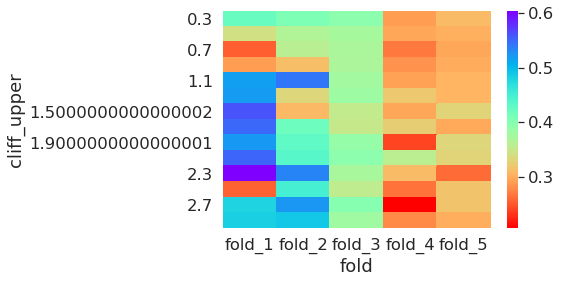

In [53]:
sns.heatmap(res, cmap = 'rainbow_r')

<AxesSubplot:xlabel='cliff_upper'>

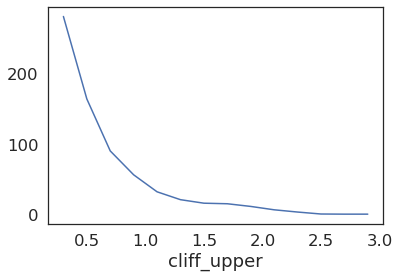

In [54]:
df.groupby(['cliff_upper', 'fold']).val_n_triplets.max().unstack().T.mean().plot()

<AxesSubplot:xlabel='cliff_upper'>

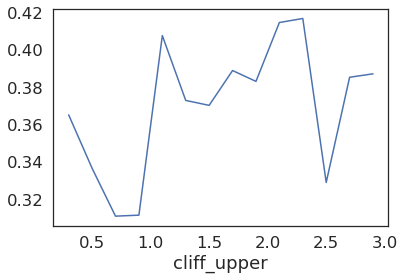

In [55]:
df.groupby(['cliff_upper', 'fold']).val_rmse.min().unstack().T.mean().plot()

In [56]:
df.groupby(['cliff_upper', 'fold']).val_rmse.min()

cliff_upper  fold  
0.3          fold_1    0.423201
             fold_2    0.407258
             fold_3    0.395338
             fold_4    0.290422
             fold_5    0.310700
                         ...   
2.9          fold_1    0.484427
             fold_2    0.490316
             fold_3    0.381255
             fold_4    0.278575
             fold_5    0.302448
Name: val_rmse, Length: 70, dtype: float64

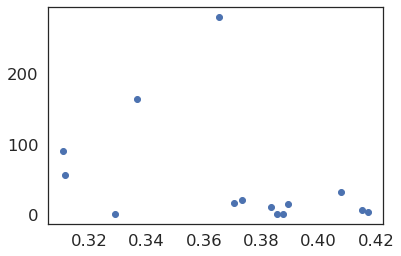

In [57]:
plt.scatter(df.groupby(['cliff_upper', 'fold']).val_rmse.min().unstack().T.mean(), 
            df.groupby(['cliff_upper', 'fold']).val_n_triplets.max().unstack().T.mean() )

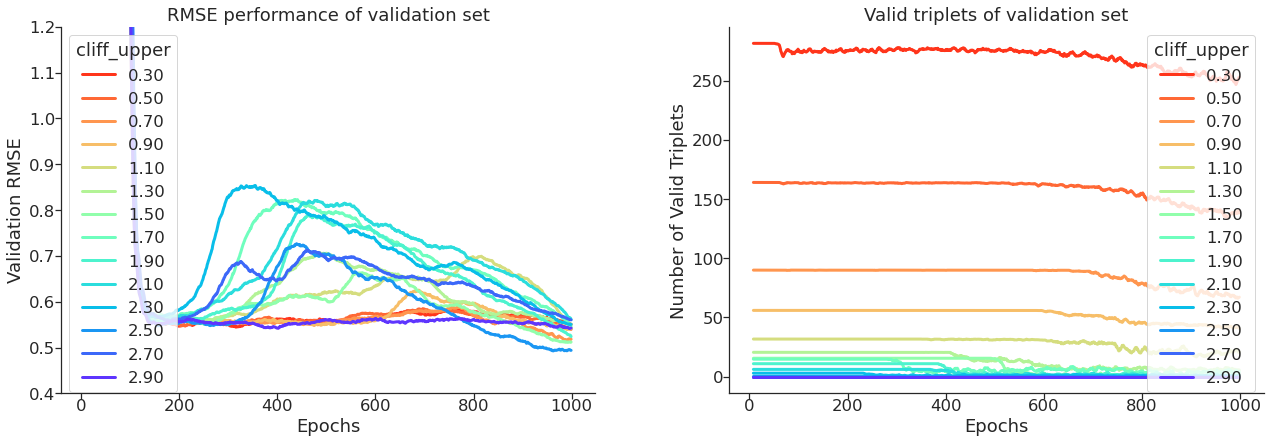

In [58]:
dfg = df.groupby([ 'Epoch', 'cliff_upper']).mean()

dfp1 = dfg['val_rmse'].unstack()
dfp2 = dfg['val_n_triplets'].unstack()

dfp1.columns = dfp1.columns.map(lambda x:'%.2f' % x)
dfp2.columns = dfp2.columns.map(lambda x:'%.2f' % x)

# dfp1.columns.name = 'cliff'
# dfp2.columns.name = 'cliff'


# dfp1 = dfp1[['0.50', '1.00', '1.50', '2.00', '2.50']]
# dfp2 = dfp2[['0.50', '1.00', '1.50', '2.00', '2.50']]


color = sns.color_palette("rainbow_r", len(dfp1.columns)) #PiYG
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,6.5), sharex=True, sharey=False, )
ax1, ax2 = axes        

dfp2.rolling(8).mean().plot(ax=ax2, lw = 3, color = color)

dfp1.rolling(50).mean().plot(ax=ax1, lw = 3, color = color)

ax1.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
ax2.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)

ax1.set_ylim(0.4, 1.2)

ax1.set_ylabel('Validation RMSE')
ax1.set_xlabel('Epochs')

ax2.set_ylabel('Number of Valid Triplets')
ax2.set_xlabel('Epochs')

ax1.set_title('RMSE performance of validation set')
ax2.set_title('Valid triplets of validation set')

sns.despine(top=True, right=True, left=False, bottom=False)

fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25)
#plt.savefig(os.path.join(save_dir, 'genotype-phenotype-10FCV_10t_valid_auc.pdf'), bbox_inches='tight', dpi=400)

<AxesSubplot:xlabel='cliff_upper'>

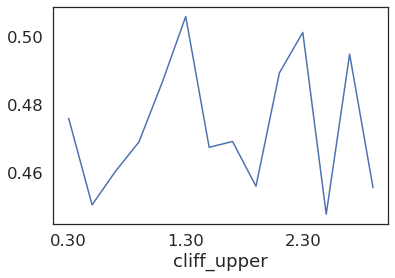

In [59]:
dfp1.min().plot()

<AxesSubplot:xlabel='cliff_upper'>

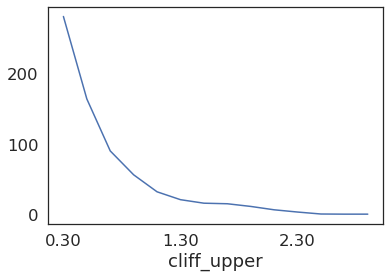

In [60]:
dfp2.max().plot()

<AxesSubplot:xlabel='cliff_upper'>

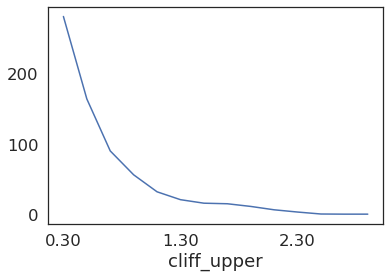

In [67]:
dfp2.max().plot()

<AxesSubplot:xlabel='cliff_upper'>

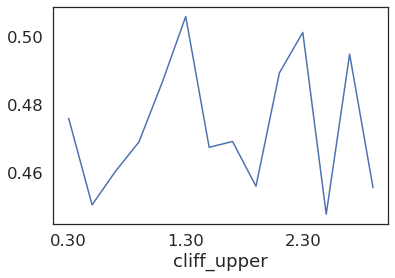

In [68]:
dfp1.min().plot()

In [63]:
for data in train_loader:
    data = data.to(device)

In [64]:
predictions, embeddings = model(data.x.float(), data.edge_index, data.edge_attr, data.batch)

In [65]:
target_l1_dist = torch.cdist(data.y,data.y,p=1) 

In [66]:
    target_l1_dist = torch.cdist(labels,labels,p=1) 
    label_equal = target_l1_dist < cliff

NameError: name 'labels' is not defined

In [ ]:
x2 = target_l1_dist > 0.2
x3 = target_l1_dist > 1


In [ ]:
x2.sum()

In [ ]:
x3.sum()

In [ ]:
    
    
def get_triplet_mask(labels, cliff, device):

    indices_equal = torch.eye(labels.shape[0]).bool()
    indices_not_equal = torch.logical_not(indices_equal)
    i_not_equal_j = torch.unsqueeze(indices_not_equal, 2)
    i_not_equal_k = torch.unsqueeze(indices_not_equal, 1)
    j_not_equal_k = torch.unsqueeze(indices_not_equal, 0)

    distinct_indices = torch.logical_and(torch.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k).to(device)

    #labels = torch.unsqueeze(labels, -1)
    #print('labels:',labels)
    target_l1_dist = torch.cdist(labels,labels,p=1) 
    label_equal = target_l1_dist < cliff
    #print('label_equal:',label_equal)
    i_equal_j = torch.unsqueeze(label_equal, 2)
    i_equal_k = torch.unsqueeze(label_equal, 1)
    valid_labels = torch.logical_and(i_equal_j, torch.logical_not(i_equal_k)).to(device)
    #print('val_indice',valid_labels[0])

    mask = torch.logical_and(distinct_indices, valid_labels)
    return mask   

In [ ]:
get_triplet_mask(data.y, cliff = 0.5, device = device).sum() 

In [ ]:
mask = get_triplet_mask(data.y, cliff = 0.1, device = device)

In [ ]:
torch.sum(mask)

In [ ]:
labels = data.y
indices_equal = torch.eye(labels.shape[0]).bool()
indices_not_equal = torch.logical_not(indices_equal)
i_not_equal_j = torch.unsqueeze(indices_not_equal, 2)
i_not_equal_k = torch.unsqueeze(indices_not_equal, 1)
j_not_equal_k = torch.unsqueeze(indices_not_equal, 0)

distinct_indices = torch.logical_and(torch.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k).to(device)

In [ ]:
distinct_indices.sum()

In [ ]:
cliff = 1
target_l1_dist = torch.cdist(labels,labels,p=1) 
label_equal = target_l1_dist < cliff
#print('label_equal:',label_equal)
i_equal_j = torch.unsqueeze(label_equal, 2)
i_equal_k = torch.unsqueeze(label_equal, 1)
valid_labels = torch.logical_and(i_equal_j, torch.logical_not(i_equal_k)).to(device)
valid_labels.sum()

In [ ]:
label_equal.sum()

In [ ]:
mask = torch.logical_and(distinct_indices, valid_labels)

In [ ]:
mask[0, 0, 0]

In [ ]:
#torch.where(True)

In [ ]:
from scipy.spatial.distance import squareform

In [ ]:
pd.Series(squareform(target_l1_dist.cpu().numpy())).hist(bins=100)

In [ ]:
torch.where(mask)[0]

In [ ]:
mask[0,3,1]

In [ ]:
predictions, embeddings = model(data.x.float(), data.edge_index, data.edge_attr, data.batch)

labels =   data.y

cliff=0.5 
alpha=0.1 
squared=False


# 得到每两两embeddings的距离，然后增加一个维度，一维需要得到（batch_size, batch_size, batch_size）大小的3D矩阵
# 然后再点乘上valid 的 mask即可

labels_dist = (labels - labels.T).abs()  

margin_pos =  labels_dist.unsqueeze(2)
margin_neg =  labels_dist.unsqueeze(1)
margin = margin_neg - margin_pos

pairwise_dis = pairwise_distance(embeddings=embeddings, squared=squared)
anchor_positive_dist = pairwise_dis.unsqueeze(2)
assert anchor_positive_dist.shape[2] == 1, "{}".format(anchor_positive_dist.shape)
anchor_negative_dist = pairwise_dis.unsqueeze(1)
assert anchor_negative_dist.shape[1] == 1, "{}".format(anchor_negative_dist.shape)
#triplet_loss = anchor_positive_dist - anchor_negative_dist + margin
triplet_loss = anchor_positive_dist - anchor_negative_dist + margin

mask = get_triplet_mask(labels=labels, cliff = cliff, device=device )
mask = mask.float()

triplet_loss = torch.mul(mask, triplet_loss)
triplet_loss = torch.maximum(triplet_loss, torch.tensor([0.0]).to(device))
# 计算valid的triplet的个数，然后对所有的triplet loss求平均
valid_triplets = (triplet_loss> 1e-16).float()
num_positive_triplets = torch.sum(valid_triplets)
num_valid_triplets = torch.sum(mask) #100, (a, p, n) #

# #print(num_valid_triplets, mask.shape)

# triplet_loss = torch.sum(triplet_loss) / (num_valid_triplets + 1e-16)
# mae_loss = torch.mean((labels-predictions).abs())
# union_loss = mae_loss + alpha*triplet_loss


In [ ]:
torch.sum(mask)

In [ ]:
torch.where(valid_triplets)

In [ ]:
num_positive_triplets

In [ ]:
def get_triplet_mask2(labels, device, cliff_lower = 0.2, cliff_upper=1.0):

    indices_equal = torch.eye(labels.shape[0]).bool()
    indices_not_equal = torch.logical_not(indices_equal)
    i_not_equal_j = torch.unsqueeze(indices_not_equal, 2)
    i_not_equal_k = torch.unsqueeze(indices_not_equal, 1)
    j_not_equal_k = torch.unsqueeze(indices_not_equal, 0)

    distinct_indices = torch.logical_and(torch.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k).to(device)

    #labels = torch.unsqueeze(labels, -1)
    #print('labels:',labels)
    target_l1_dist = torch.cdist(labels,labels,p=1) 
    label_equal = target_l1_dist < cliff_lower #0.5
    label_unequal  = target_l1_dist > cliff_upper #1.5
    
    #print('label_equal:',label_equal)
    i_equal_j = torch.unsqueeze(label_equal, 2)
    #i_equal_k = torch.unsqueeze(label_equal, 1)
    i_unequal_k = torch.unsqueeze(label_unequal, 1)
    
    valid_labels = torch.logical_and(i_equal_j, i_unequal_k).to(device)
    #print('val_indice',valid_labels[0])

    mask = torch.logical_and(distinct_indices, valid_labels)
    return mask  

In [ ]:
mask2 = get_triplet_mask2(labels, device, cliff_lower = 0.3, cliff_upper=1.0)
mask = get_triplet_mask(labels, cliff = 1., device = device)

In [ ]:
torch.where(mask2)

In [ ]:
torch.where(mask)

In [ ]:
torch.where(mask2)[0].shape

In [ ]:
torch.where(mask)[0].shape

In [ ]:
10**0.3